# An Analysis of the Titanic Disaster
Tutorial by Eric Schneider and Sachin Mansukhani

# The Titanic Disaster

Almost everyone is familiar with the Titanic, a ship that set sail April 10, 1912 and struck an iceberg around April 15, 1912. Unfortunately, the ship was not equipped with the proper installments to keep itself afloat, and a good percentage of life was lost. There seems to be many different factors to take into account when addressing the Titanic disaster. This tutorial will investigate the tragedy of the Titanic crash, using data science, regression and machine learning to try to predict what passengers survived the disaster. By creating models, we can better predict the future, but also better analyze the past. The Titanic remains one of the world's most famous disasters and still captivates people and historians to this day.

# Data Collection

For our dataset, we used [Kaggle's Titanic dataset](https://www.kaggle.com/c/titanic/overview), which was originally published for a machine learning competition. 

In [1]:
# Import the required packages for tutorial
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import graphviz

In [2]:
# Open the dataset from Kaggle and put it into a dataframe
titanic_data = pd.read_csv('train.csv')

# We will be using holdout validation in order to see the accuracy of our model. Split the data with
# 20% being used for testing.
titanic_data, testing = train_test_split (titanic_data,test_size = 0.20, random_state = 42)

titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
331,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S
733,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S
382,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S
704,705,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S


There are a number of different categorizations made by the data which are discussed below:
* survival	- **Survival**	    *(0 = No, 1 = Yes)*
* pclass	- **Ticket class**	*(1 = 1st, 2 = 2nd, 3 = 3rd)*
* Sex       - **Sex**
* Age	    - **Age**
* sibsp	    - **Number of siblings / spouses aboard the Titanic**	
* parch	    - **Number of parents / children aboard the Titanic**	
* ticket	- **Ticket number**	
* fare	    - **Passenger fare**	
* cabin	    - **Cabin number**	
* embarked	- **Port of Embarkation** *(C = Cherbourg, Q = Queenstown, S = Southampton)*

Some additional notes about the variable data that Kaggle includes are the following:
* pclass: A proxy for socio-economic status (SES)
    1st = Upper
    2nd = Middle
    3rd = Lower

* age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

* sibsp: The dataset defines family relations in this way...
    Sibling = brother, sister, stepbrother, stepsister
    Spouse = husband, wife (mistresses and fiancés were ignored)

* parch: The dataset defines family relations in this way...
    Parent = mother, father
    Child = daughter, son, stepdaughter, stepson
    Some children travelled only with a nanny, therefore parch=0 for them.
    
Given these classifications, we began to think of the possible ways that we could build a model to predict if a passenger on the Titanic survived.

# Exploratory Data Analysis

Firstly, we decided to just graph some of categorizations from the dataset with their survival rate to see if there was any initial trends with the data.

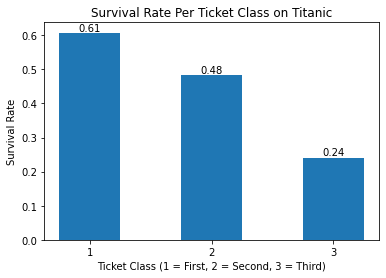

In [3]:
# Graph the survival rate among 1st, 2nd, and 3rd classees

# Calculate the percentage of passengers who survived in each class
classes_numbers = titanic_data.groupby(["Pclass", 'Survived']).size()
classes_totals = titanic_data.groupby("Pclass").size()
class_one_survived = classes_numbers[1][1] / classes_totals[1]
class_two_survived = classes_numbers[2][1] / classes_totals[2]
class_three_survived = classes_numbers[3][1] / classes_totals[3]

# Create a bar graph with three bars, each showing the percentage of passengers who survived in a class
xs = [1,2,3]
ys = [class_one_survived, class_two_survived, class_three_survived]
plt.bar(xs, ys, width = 0.5)
plt.xticks(np.arange(1, 4, step=1))
plt.xlabel('Ticket Class (1 = First, 2 = Second, 3 = Third)')
plt.ylabel('Survival Rate')
plt.title('Survival Rate Per Ticket Class on Titanic')

# Label bars on graph
for x,y in zip(xs,ys):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,2), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

At an initial glance, there is an association with ticket class and overall survival rate among Titanic boarders. It seems as if if you are in better ticket class, you had a better chance of surviving compared to a lower ticket class. The graph shows that 61% of passengers in first class survived, while only 24% of passengers in third class survived. Since there was a limited amount of lifeboats on the ship (sources say there was 20 lifeboats, enough for 1178 people), it left 48% of the passangers without a lifeboat if a disaster were to happen. With that being said, one would assume the protocol for a rescue would be getting the first class passengers out first (Barczewski, 2006). Some historians say that the crew was not even prepared to carry out an evacuation, but the consensus seems to be that many boats were used to save the women and children first. Considering this, we took a look at the survival rate of women and children vs men. *Barczewski, Stephanie (2006). Titanic: A Night Remembered. London: Hambledon Continuum. ISBN 978-1-85285-500-0.*

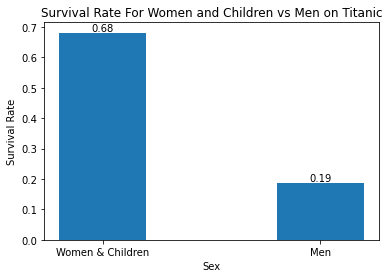

In [4]:
# Sort survival by sex
sex_numbers = titanic_data.groupby(["Sex", 'Survived']).size()

# Find the amount of children and count how many survived
children_numbers = titanic_data[titanic_data['Age'] < 18]
children_numbers = children_numbers['Survived'].value_counts()

# Calculate total women and children survived and totals
wc_survived = (sex_numbers[1] + children_numbers[1]) / (sex_numbers[1]+sex_numbers[0]+children_numbers[0]+children_numbers[1])
# Calculate total men survived and totals
men_survived  = (sex_numbers[3]) / (sex_numbers[2] + sex_numbers[3])

# Plot a bar chart using matplotlib of the percentage of women and children who survived vs. men who survived
xs = ['Women & Children', 'Men']
ys = [wc_survived, men_survived]
plt.bar(xs, ys, width = 0.4)
plt.xlabel('Sex')
plt.ylabel('Survival Rate')
plt.title('Survival Rate For Women and Children vs Men on Titanic')

# Label bars on graph
for x,y in zip(xs,ys):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,2), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

After an initial look, it seems as there is a correlation between being a woman/child and survivng the Titanic. Overall, men had a much lower survival rate of .19 compared to women and children's survival rate of .68, so it seems Barczewski may be correct in his assumption that women and children were unloaded first. We decided to make a new column indicating if the passenger was a female or a child.

In [5]:
# Iterate through rows, indicating whether or not each passenger is a woman/child or a man
for row, col in titanic_data.iterrows():
    if titanic_data.at[row, 'Sex'] == 'female' or titanic_data.at[row, 'Age'] < 18:
        # FC = female or child
        titanic_data.at[row, 'FC'] = 1
    else:
        titanic_data.at[row, 'FC'] = 0
    # Translate male and female to 1 and 0 to have it register on the heatmap
    if titanic_data.at[row, 'Sex'] == 'male':
        titanic_data.at[row, 'Sex'] = 0
    else: 
        titanic_data.at[row, 'Sex'] = 1
        
print('FC: Male = 0, Female/Child = 1')
titanic_data.head()

FC: Male = 0, Female/Child = 1


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FC
331,332,0,1,"Partner, Mr. Austen",0,45.5,0,0,113043,28.5000,C124,S,0.0
733,734,0,2,"Berriman, Mr. William John",0,23.0,0,0,28425,13.0000,NaN,S,0.0
382,383,0,3,"Tikkanen, Mr. Juho",0,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S,0.0
704,705,0,3,"Hansen, Mr. Henrik Juul",0,26.0,1,0,350025,7.8542,NaN,S,0.0
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",1,6.0,4,2,347082,31.2750,NaN,S,1.0


Next, we implemented a heatmap of correlations in the dataset to truly understand where the most convincing correlations lie.

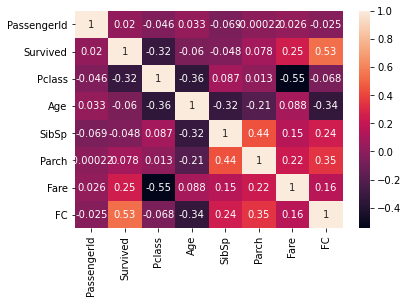

In [6]:
# Create a heatmap of correlations between the columns in the dataset

corr = titanic_data.corr()
sn.heatmap(corr, annot = True)
plt.show()

The three most correlated variables with Survived in the Titanic data include PClass with a -0.34 rating, Fare with a 0.26 rating, and the female/child variable with a 0.53 rating.
* **Pclass**: Pclass with a negative correlation confirms our initial analysis and suspicion that more 1st class people survived the 
    Titanic crash. It is a negative correlation as once one goes up in your ticket class (1, 2, 3), they are more likely to not 
    survive.
    
* **Fare**: Fare is positively associated with Survival at a 0.26 rating, meaning there is some positive correlation between fare price and survival. Again, this may be associated with Pclass as the more expensive a ticket, the more likely they are in a higher Socio-economic status. This can be confirmed by the negative correlation between Fare and Pclass (negative since 1st class = higher ticket price).

* **Female/Child**: The female/child category yielded a positive correlation with Survival at a rating of 0.53. The highest correlation among the variables, we will investigate if this is a significant assumption. 

Following the heatmap of correlated survival variables, we decided to do an R$^2$ analysis where if the p-value is less than 0.05, the variables are significantly correlated. We decided to use Ordinary Least Squares analysis and create a Linear Regression model to show the results.

# Hypothesis Testing/Machine Learning: Linear Regression

In [7]:
# Use statsmodel to build a linear regression model with "Survived" on the y-axis and "Fare" on the x-axis

td_no_na = titanic_data.dropna()
X = td_no_na['Fare']
y = td_no_na['Survived']
f_model = sm.OLS(y, sm.add_constant(X)).fit()
f_params = f_model.params
print('Fare vs. Survived model Summary')
f_model.summary()

Fare vs. Survived model Summary


/Users/sachinmansukhani/opt/anaconda3/envs/CMSC320/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Survived   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.491
Date:                Sun, 19 Dec 2021   Prob (F-statistic):              0.117
Time:                        14:16:37   Log-Likelihood:                -95.080
No. Observations:                 143   AIC:                             194.2
Df Residuals:                     141   BIC:                             200.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5935      0.057     10.479      0.000       0.482       0.705
Fare           0.0008      0.000      1.578      0.117      -0.000       0.002
==============================================================================
Omnibus:                     2932.093   Durbin-Watson:                   2.187
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.716
Skew:                          -0.640   Prob(JB):                     7.08e-06
Kurtosis:                       1.469   Cond. No.                         165.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Even though the heatmap showed some sort of correlation between "Fare" and "Survived", the R^2 value of .017 is very low. We are looking to get the R^2 value closer to 1. Let's plot the data points with the linear regression model we just created to see what happened.

<AxesSubplot:xlabel='Fare', ylabel='Survived'>

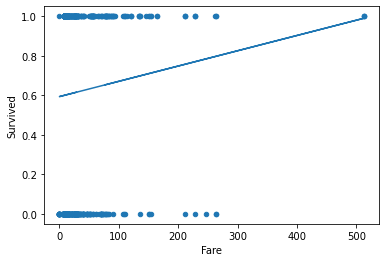

In [8]:
# Make a scatter plot of "Fare" vs. "Survived", with the line generated by statsmodel

ax = titanic_data.plot(kind='scatter', x='Fare', y='Survived')
x = titanic_data["Fare"]
ax.plot(x, f_params.const + f_params.Fare * x)
ax

It turns out for binary predictions (survived or not), linear regression is not the best model to use. As seen above, the y-values are only at 0 or 1, so there will not be a linear relationship between the data. Logistic regression works much better for these situations (Mondal 2020). We will create a logistic regression model to predict whether a passenger survived instead. First, we will try to make a model with all the categories in the table. Any category/variable that is not statistically significant in our model can be removed in the final model. A statistically significant variable is one that seems to have influence in predicting if a passenger survived.

# Hypothesis Testing/Machine Learning: Logistic Regression

In [9]:
# Name, ticket, and passenger ID are simply identifiers and do not need to be used in our model.
# Cabin is unfortunately missing a lot of data and instead of sex, we will use our "FC" column.
# Every other category will be put in our initial model.
res = smf.logit(formula='Survived ~ C(Pclass) + C(FC) + Age + SibSp + Parch + Fare + C(Embarked)', data=titanic_data).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.443065
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  570
Model:                          Logit   Df Residuals:                      560
Method:                           MLE   Df Model:                            9
Date:                Sun, 19 Dec 2021   Pseudo R-squ.:                  0.3430
Time:                        14:16:37   Log-Likelihood:                -252.55
converged:                       True   LL-Null:                       -384.41
Covariance Type:            nonrobust   LLR p-value:                 1.253e-51
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1770      0.552      0.321      0.749      -0.905       1.259
C(Pclass)[T.2]      -0.6789      0.372     -1.824      0.068      -1.408       0.051
C(Pclass)[T.3]      -1.8663      0.386     -4.833      0.000      -2.623      -1.109
C(FC)[T.1.0]         2.9476      0.270     10.918      0.000       2.418       3.477
C(Embarked)[T.Q]    -0.9350      0.671     -1.394      0.163      -2.250       0.380
C(Embarked)[T.S]    -0.6404      0.315     -2.035      0.042      -1.257      -0.024
Age                 -0.0064      0.009     -0.690      0.490      -0.024       0.012
SibSp               -0.4175      0.128     -3.268      0.001      -0.668      -0.167
Parch               -0.1671      0.145     -1.152      0.249      -0.451       0.117
Fare                 0.0031      0.003      1.057      0.290      -0.003       0.009
====================================================================================
"""

Looking at the p-values for the logistic regression model, most of the variables in the table had significant p-values (less than 0.05). Age, Parch (number of parents and children aboard ship), and Fare all did not have a significant p-value, so we can remove those categories from our final model.

In [10]:
# Make a new model with only the statistically significant variables.
res = smf.logit(formula='Survived ~ C(Pclass) + C(FC) + SibSp + C(Embarked)', data=titanic_data).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.436762
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  710
Model:                          Logit   Df Residuals:                      703
Method:                           MLE   Df Model:                            6
Date:                Sun, 19 Dec 2021   Pseudo R-squ.:                  0.3396
Time:                        14:16:37   Log-Likelihood:                -310.10
converged:                       True   LL-Null:                       -469.58
Covariance Type:            nonrobust   LLR p-value:                 7.049e-66
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0020      0.269     -0.007      0.994      -0.529       0.525
C(Pclass)[T.2]      -0.7026      0.296     -2.377      0.017      -1.282      -0.123
C(Pclass)[T.3]      -1.9616      0.268     -7.325      0.000      -2.486      -1.437
C(FC)[T.1.0]         2.9882      0.227     13.152      0.000       2.543       3.433
C(Embarked)[T.Q]    -0.2068      0.427     -0.485      0.628      -1.043       0.629
C(Embarked)[T.S]    -0.6496      0.268     -2.425      0.015      -1.175      -0.124
SibSp               -0.4115      0.105     -3.922      0.000      -0.617      -0.206
====================================================================================
"""

We are now going to see the accuracy of our model by using it to predict if a passenger survived on the testing data. First, we must add the FC category to the testing data.

In [11]:
# We must transform the testing data to also have the "FC" column.

# Iterate through rows, indicating whether or not each passenger is a woman/child or a man
for row, col in testing.iterrows():
    if testing.at[row, 'Sex'] == 'female' or testing.at[row, 'Age'] < 18:
        # FC = female, child
        testing.at[row, 'FC'] = 1
    else:
        testing.at[row, 'FC'] = 0
print('FC: Male = 0, Female/Child = 1')
testing.head()

FC: Male = 0, Female/Child = 1


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FC
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C,0.0
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S,0.0
840,841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S,0.0
720,721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.0000,NaN,S,1.0
39,40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,NaN,C,1.0


Accuracy: 0.79%


Text(0.5, 257.44, 'Predicted label')

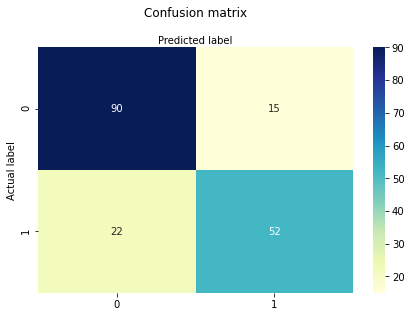

In [12]:
# Keep only the columns of testing data needed and then predict if passenger survived based on model.
x_test = testing[["Pclass", "FC", "Embarked", "SibSp"]]
predictions = res.predict(x_test)

# Predictions will not come out to be binary 0 or 1, but instead a range of values between them.
# Predictions less than 0.5 will be said to predict the passenger did not survive.
y_pred = np.where(predictions > 0.5, 1, 0)

y_ans = testing["Survived"]

# Calculate the accuracy of our model, comparing our predictions to the "Survived" column in the testing data.
accuracy = accuracy_score(y_ans, y_pred)
print('Accuracy: %.2f' % accuracy + "%")

# Calculate confusion matrix for model, print out in form of heat map
matrix = confusion_matrix(y_ans, y_pred)
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sn.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Our model had an accuracy of 79% in predicting if a passenger survived in the training data. That's pretty good! Additionally, the heatmap above describes a confusion matrix for the model. To describe how the confusion matrix works, the top left box identifies how many true negatives the model predicts, the top right -- false positives, the bottom right -- true positives, and bottom left -- false negatives. Therefore, the logistic regression model had about 90 true negatives and 52 true positives. On the other hand, it had about 22 false negatives and 15 false positives. Therefore, the logisitic regression model seemed to be better at accurately predicting that a passenger did not survive versus accurately predicting that a passenger survived. Let's try to compare our logistic regression with another classifier, a decision tree.

# Hypothesis Testing/Machine Learning: Decision Tree

We will be using a decision tree with the same variables used in our final logistic regression model. PClass and FC are categorical variables, but have numerical values, so sci-kit learn can handle them. On the other hand, "Embarked" is not categorical and not ordinal, so we will use one-hot encoding.

In [13]:
# One-hot encode the "Embarked" column of the dataset (for both training and testing data).
titanic_data = pd.get_dummies(titanic_data,columns=['Embarked'])
x_test = pd.get_dummies(x_test, columns = ["Embarked"])

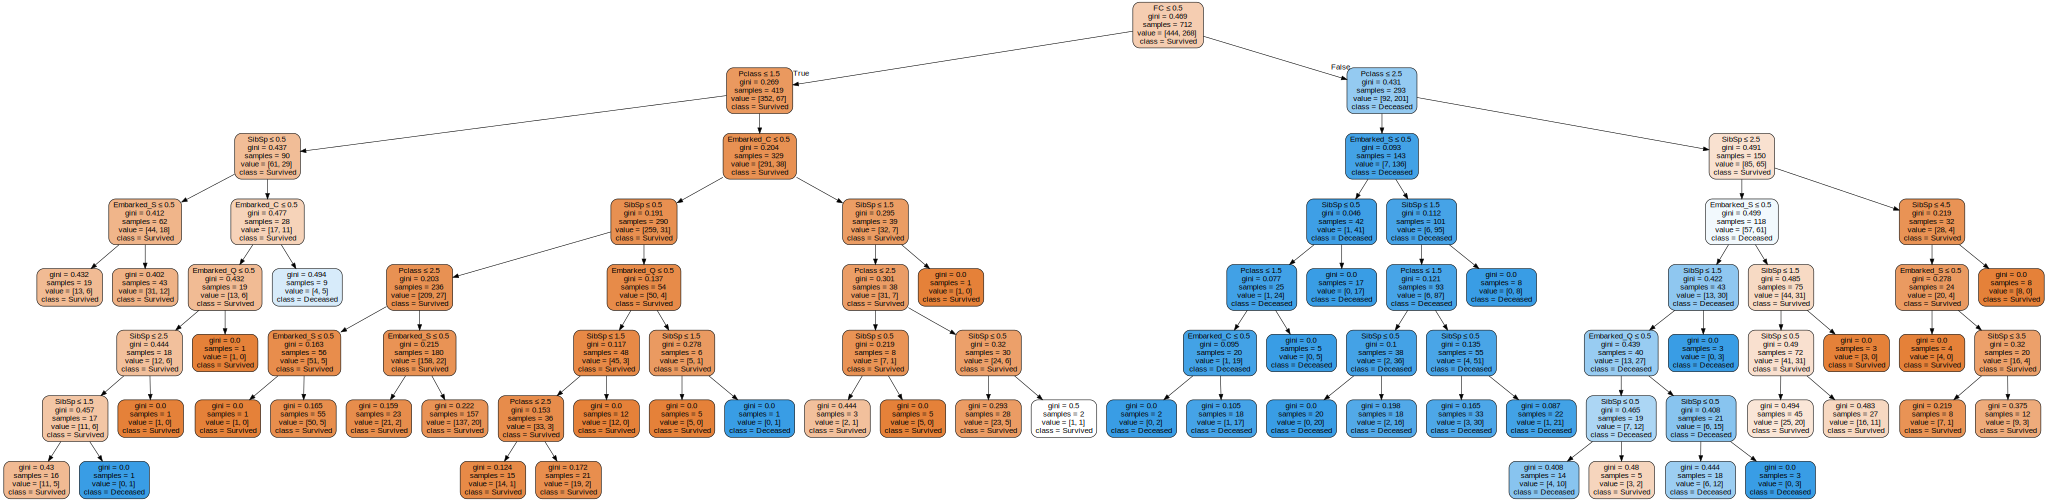

In [14]:
# Build a decision tree and display the tree using graphviz.

clf = tree.DecisionTreeClassifier(random_state = 42)
X_train = titanic_data[["Pclass", "FC", "Embarked_C", "Embarked_Q", "Embarked_S", "SibSp"]]
Y_train = titanic_data["Survived"]
clf = clf.fit(X_train, Y_train)

dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X_train.columns, class_names=["Survived", "Deceased"], filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

This tree looks pretty complex, with lots of leaf nodes. This tree may be overfitting and not perform well on the test data. Let's check the accuracy of our decision tree model to see if we should add some hyperparameters.

Accuracy: 0.78%


Text(0.5, 257.44, 'Predicted label')

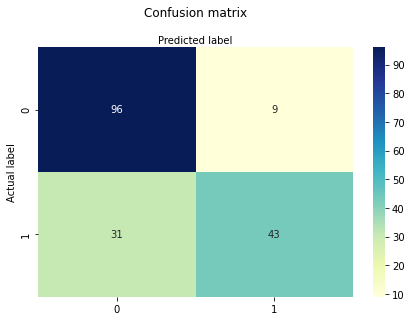

In [15]:
# Calculate the accuracy of our decision tree on the testing data.

predictions = clf.predict(x_test)
accuracy = accuracy_score(y_ans, predictions)
print('Accuracy: %.2f' % accuracy + "%")

# Calculate confusion matrix for model, print out in form of heat map
matrix = confusion_matrix(y_ans, predictions)
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sn.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

The logistic regression model's accuracy was 79% accurate while the decision tree accuracy was 78%. Both models are accurate in determining the survival rate of Titanic survivors as ~ 80% accuracy score is typically a good accuracy score. If we had more data, perhaps we could increase this rate, but for the data we have, an 80% accuracy score is sufficient. As said before, the decision tree was quite complex. The accuracy was quite high, however, so there does not seem to be much of a problem of overfitting. It's worth noting that the decision tree yielded 31 false negatives and 9 false positives. Although this model is different, it still would often incorrectly predict a passenger did not survive.

## Final Thoughts

While analyzing the Titanic dataset, we made many intriguing insights into the Titanic disaster. Firstly, while doing some initial research and observations, we figured that survival rate was correlated with the passenger's ticket class (Pclass) and found that the survival rate of the 1st class ticket holders was higher than the 2nd and 3rd class passengers. Next, after doing research into the evacuation procedures, women and children were typically the first people to be evacuated, so we investigated the survival rates of women and children vs. men.

Next, to model the survival of passengers we used a linear regression model, but found that this model does not suit the data well as the R^2 values were very close to 0. Instead, we decided to use a logistic regression model to predict the data. We learned that linear regression models usually do not work with binary values, and logistic regression typically work better. We created a successful logistic regression model by filtering out the unimportant variables and analyzing the final outputs of the model. Looking at the p-values of the variables used in the logistic regression model, we found that passenger class, port of embarkation, whether they were a female/child or not, and the amount of siblings and spouses were the most important factors in predicting if a passenger on the Titanic would survive. With these variables, we could create a logistic regression model with a high accuracy of 79%.

We then created a decision tree classifier, using the same variables that we found to be the most important when crafting our logistic regression model. Although our decision tree was complex, it ended up having a similar accuracy of 78% on the testing data. Both of our models had a high amount of false negatives, meaning that it predicted a passenger did not survive when in reality, they did survive. Something we could've done differently is maybe used 10-fold cross validation for the decision tree. This may have yielded a more accurate decision tree model, but instead we opted to be consistent and use hold-out validation (with the same training and testing dataset) for both logistic regression and the decision tree classifier.

Next time, we would look to improve our models' accuracy by possibly incorporating another dataset and more values, or perhaps changing our approach in filtering the variables. We also could have tried to impute the missing "Cabin" data and see if that would've been statistically significant in our logistic regression model. Overall, we looked into analyzing the Titanic dataset by finding what factors were most important and correlated to a passenger's survival in one of the most popular tragedies in history. By doing so, we were able to build two different models that could predict if a passenger survived with both having roughly 80% accuracy.

# Sources and Further Resources

Source
* Barczewski, Stephanie (2006). Titanic: A Night Remembered. London: Hambledon Continuum. ISBN 978-1-85285-500-0.
* Mondal, Sourav. "Beginners Take: How Logistic Regression is related to Linear Regression." Analytics Vidhya, 1 Dec. 2020, https://www.analyticsvidhya.com/blog/2020/12/beginners-take-how-logistic-regression-is-related-to-linear-regression/. 
* Vander Hook, S. (2008). Titanic. Edina, Minnesota: ABDO Publishing Company., p. 18.

Further Resources
* [Linear Regression in Python](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
* [Linear Regression Example](https://www.w3schools.com/python/python_ml_linear_regression.asp)
* [Logistic Regression in Python](https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/)
* [Decision Trees](https://scikit-learn.org/stable/modules/tree.html)
* [Heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html)
* [Titanic Dataset Kaggle](https://www.kaggle.com/c/titanic/data)